# Exploratory data analysis for time series

1. Descriptive statistics
2. Descriptive statistics over sliding windows
3. Temporal correlations (auto-correlation, cross-correlation)
3. Scatter plots with possible differencing to mitigate temporal dependencies, connecting scatter plots in order
4. Seasonal decomposition
5. Features extraction (elementary summaries) plus standard cross-sectional exploratory data analysis
6. Simple models (naïve baselines, common baseline models), specific to learning task

In [8]:
from utils import load_temperature
from utils import load_pressure

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Single series

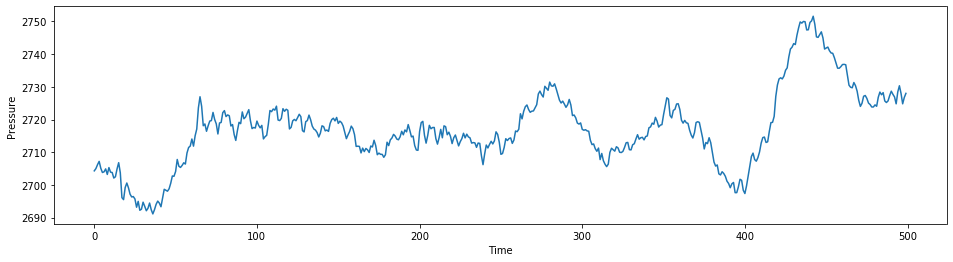

In [9]:
pressure = load_pressure()
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pressure.plot(ax=ax)
ax.set(ylabel="Pressure", xlabel="Time");

### Descriptive statistics
* Basic descriptive stats, but note that common uncertainty quantifications like confidence intervals and standard errors have to be interpreted carefully as samples are not i.i.d.

In [10]:
pressure.describe()

count     500.00000
mean     2717.10828
std        11.41151
min      2691.12500
25%      2711.27000
50%      2716.51000
75%      2722.77250
max      2751.60500
Name: pressure, dtype: float64

#### Many more time series specific statistics: 
* https://www.statsmodels.org/stable/tsa.html
* https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

### Descriptive statistics with rolling window
* uses past and present data to compute descriptive statistics, so not suitable for online learning setting (e.g. anomaly detection in real time)

#### Rolling mean

In [11]:
window_length = 10  # typically set to the seasonal periodicity, i.e. the period per year, e.g. 12 for monthly data

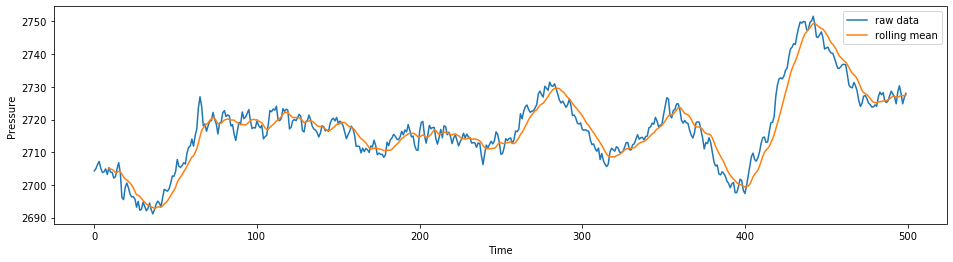

In [12]:
pressure = load_pressure()
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pressure.plot(ax=ax, label="raw data")
yt = pressure.rolling(window_length).mean()
yt.plot(ax=ax, label="rolling mean")
ax.set(ylabel="Pressure", xlabel="Time")
plt.legend();

#### Rolling mean with rolling standard deviation

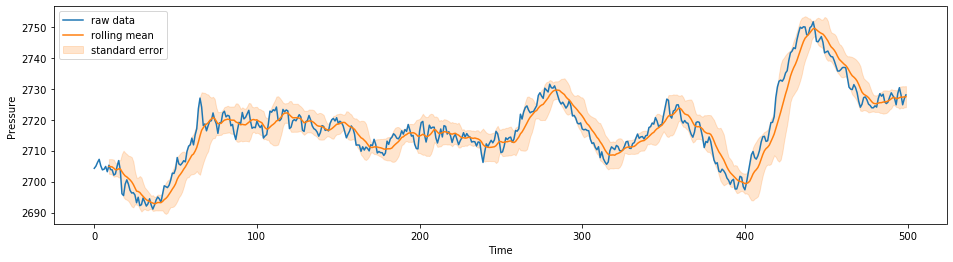

In [13]:
pressure = load_pressure()
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pressure.plot(ax=ax, label="raw data")
yt = pressure.rolling(window_length).mean()
yt.plot(ax=ax, label="rolling mean");
rolling_std = pressure.rolling(window_length).std()
ax.fill_between(pressure.index, yt + (2 * rolling_std), yt - (2 * rolling_std), alpha=0.2, color=u'#ff7f0e', label="standard error")
ax.set(ylabel="Pressure", xlabel="Time")
plt.legend();

#### Rolling quantiles

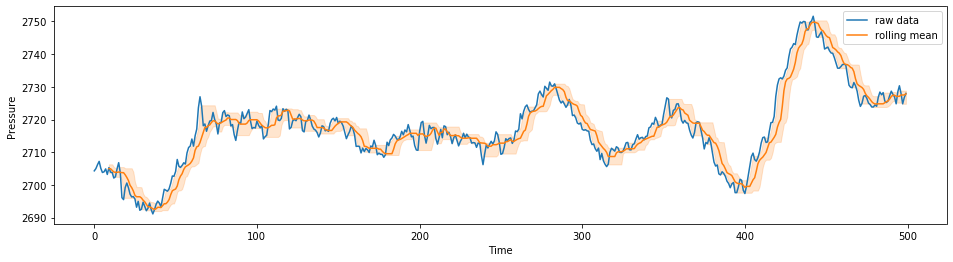

In [14]:
pressure = load_pressure()
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pressure.plot(ax=ax, label="raw data")
q1 = pressure.rolling(window_length).quantile(.1)
median = pressure.rolling(window_length).quantile(.5)
q3 = pressure.rolling(window_length).quantile(.9)
median.plot(ax=ax, label="rolling mean");
rolling_std = pressure.rolling(window_length).std()
ax.fill_between(pressure.index, q1, q3, alpha=0.2, color=u'#ff7f0e')
ax.set(ylabel="Pressure", xlabel="Time")
plt.legend();

#### Exponential weighted mean

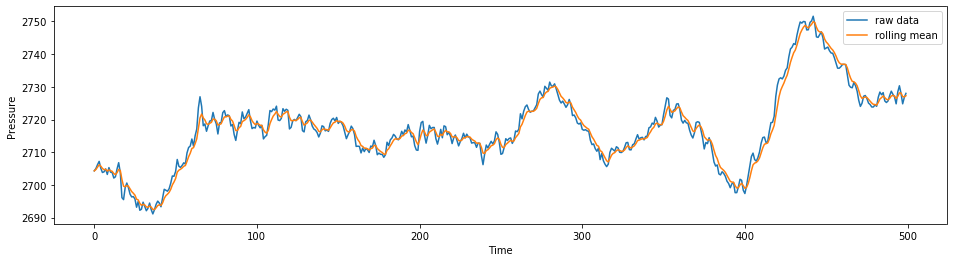

In [15]:
pressure = load_pressure()
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
pressure.plot(ax=ax, label="raw data")
pressure.ewm(span=5).mean().plot(ax=ax, label="rolling mean")
ax.set(ylabel="Pressure", xlabel="Time")
plt.legend();

### Autocorrelation

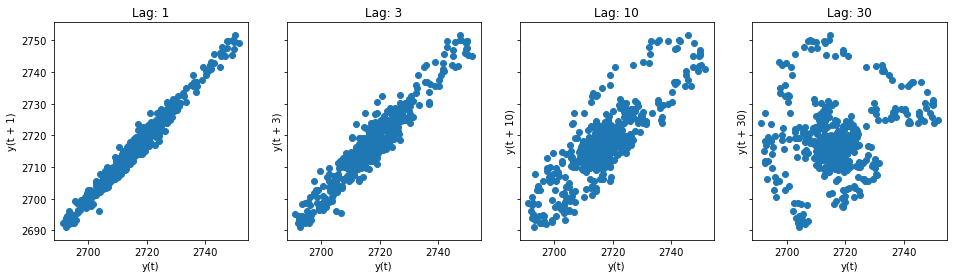

In [16]:
from pandas.plotting import lag_plot
lags = [1, 3, 10, 30]
fig, axs = plt.subplots(ncols=4, figsize=plt.figaspect(.25), sharey=True)
for k, lag in enumerate(lags):
    ax = axs[k]
    lag_plot(pressure, lag=lag, ax=ax)
    ax.set_title(f"Lag: {lag}")

In [17]:
# manual calculation
def compute_autocorr(x, lags=None):
    """
    Estimate autocorrelation for time series x and given lags
    
    References
    ----------
    ..[1] Time-Series Analysis: Forecasting and Control, 4th ed. (Box, Jenkins, Reinsel), p. 31
    """
    
    x = np.asarray(x) 
    n_timepoints = x.shape[0]
    
    mu = x.mean()
    c_0 = np.sum((x - mu)**2) / n_timepoints
    
    def corrcoef(k):
        """
        Estimate autocorrelation at lag k (sample autocorrelation function).
        """
        return np.sum((x[:-k] - mu) * (x[k:] - mu)) / n_timepoints / c_0
    
    lags = np.arange(1, n_timepoints)
    
    return np.array([1] + [corrcoef(lag) for lag in lags])

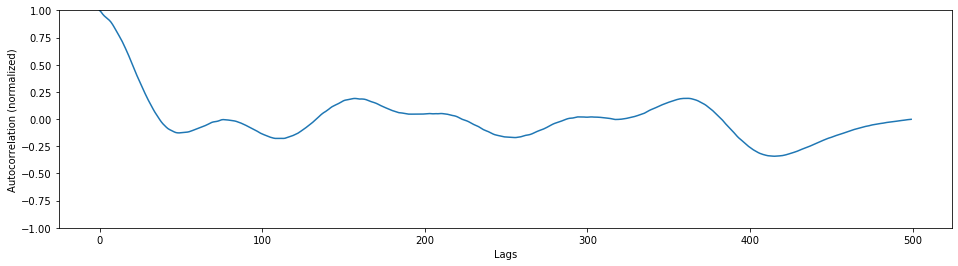

In [18]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
rho = compute_autocorr(pressure)
ax.plot(rho)
ax.set(ylim=(-1, 1), xlabel="Lags", ylabel="Autocorrelation (normalized)");

In [19]:
# using statsmodels
from statsmodels.tsa.stattools import acf
rho_statsmodels = acf(pressure, nlags=len(pressure), fft=False)
np.testing.assert_almost_equal(rho, rho_statsmodels)

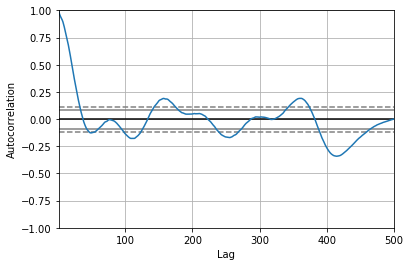

In [20]:
# using pandas
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(pressure);

In [21]:
# using numpy
# def compute_autocorr_with_np(x, lags=None):
#     x = np.asarray(x)
#     n_timepoints = x.shape[0]

#     if lags is None:
#         lags = np.arange(n_timepoints) + 1

#     return np.array([np.corrcoef(x[lag:], x[:-lag])[0, 1] for lag in lags])

### Partial autocorrelation

The partial autocorrelation at lag *k* is the partial correlation between the variables $z_t$ and $z_{t-k}$ adjusted for the intermediate
variables $z_{t-1}, z_{t-2} ... z_{t-k+1}$. In other words, the correlation between $z_t$ and $z_{t-k}$ not accounted for by $z_{t-1}, z_{t-2} ... z_{t-k+1}$. 

* [Partial correlation](https://en.wikipedia.org/wiki/Partial_correlation) 

In [22]:
# using statsmodels
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
pacf(pressure, nlags=10)

array([ 1.        ,  0.98626245, -0.17510467,  0.16772035,  0.06404346,
        0.00938107, -0.04624548, -0.09897693, -0.18668618, -0.1094158 ,
       -0.15396139])

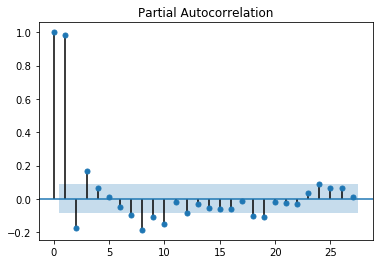

In [23]:
plot_pacf(pressure);

### Seasonal decomposition

For other decompositons, see https://otexts.com/fpp3/decomposition.html

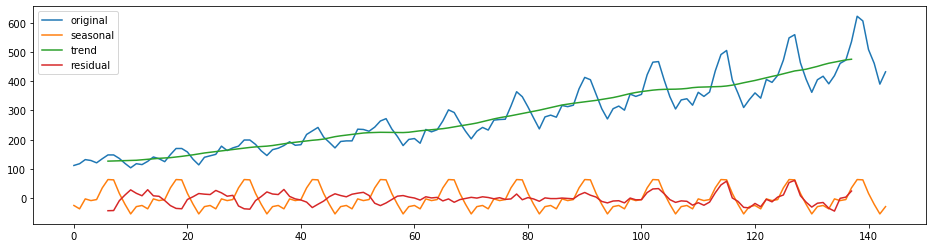

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.datasets import load_airline

y = load_airline()
decomposition = seasonal_decompose(y, model="additive", period=12)

fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
y.plot(ax=ax, label="original")
decomposition.seasonal.plot(ax=ax, label="seasonal")
decomposition.trend.plot(ax=ax, label="trend")
decomposition.resid.plot(ax=ax, label="residual")
plt.legend();

### Hypothesis testing

Time series specific hypothesis testing on 
* seasonality
* stationary 
* correlation

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.OCSBTest.html

Can also be used as heuristics in modelling 

## Multivariate time series

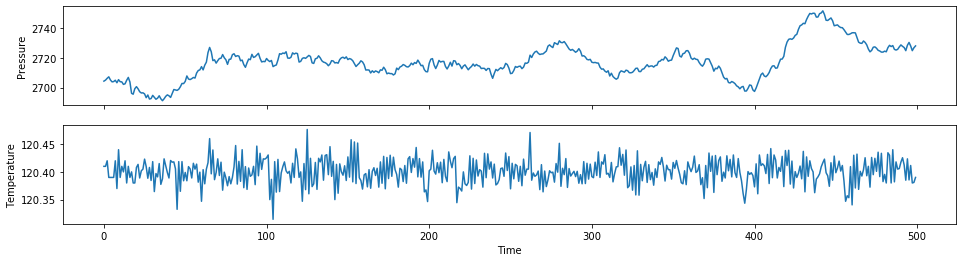

In [25]:
temperature = load_temperature()
fig, axs = plt.subplots(nrows=2, figsize=plt.figaspect(.25), sharex=True)
pressure.plot(ax=axs[0])
axs[0].set(ylabel="Pressure", xlabel="Time");
temperature.plot(ax=axs[1])
axs[1].set(ylabel="Temperature", xlabel="Time");

### Cross-correlation
* correlation between two different variables and their lagged values
* not symmetric

<img src="../images/temporal_correlation.png" width=360/>

In [66]:
# manual calculation
def compute_crosscorr(x, y):
    """
    Estimate autocorrelation for time series x and given lags
    
    References
    ----------
    ..[1] Time-Series Analysis: Forecasting and Control, 4th ed. (Box, Jenkins, Reinsel), p. 31
    """
    
    x = np.asarray(x) 
    y = np.asarray(y) 
    
    assert x.shape[0] == y.shape[0]
    n_timepoints = x.shape[0]
    
    mu_x = x.mean()
    mu_y = y.mean()
    c_0 = np.std(x) * np.std(y)
    
    def corrcoef(k):
        """
        Estimate autocorrelation at lag k (sample autocorrelation function).
        """
        return np.sum((y[:-k] - mu_y) * (x[k:] - mu_x)) / n_timepoints / c_0 
    
    lags = np.arange(1, n_timepoints)
    
    r_1 = np.corrcoef(temperature, pressure)[0, 1]
    return np.array([r_1] + [corrcoef(lag) for lag in lags])

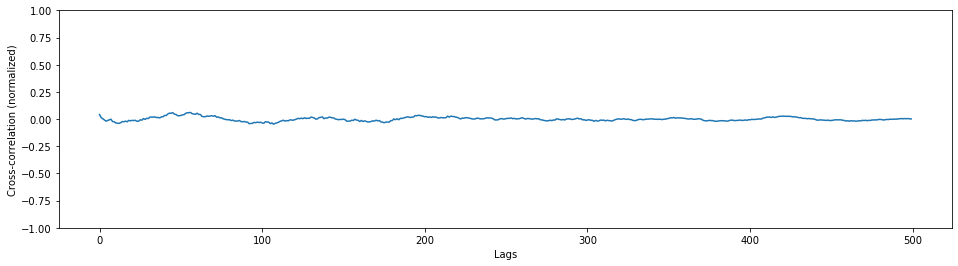

In [107]:
r = compute_crosscorr(temperature, pressure)
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
ax.plot(r)
ax.set(ylim=(-1, 1), xlabel="Lags", ylabel="Cross-correlation (normalized)");

In [108]:
# using statsmodels
r_statsmodels = ccf(temperature, pressure, unbiased=False)
np.testing.assert_array_almost_equal(r, r_statsmodels)

## Panel data

* cross-correlation across i.i.d. instances